
<h1><center>APTOS 2019 Blindness Detection</center></h1>
<h2><center>Diabetic retinopathy - SHAP model explainability</center></h2>
![](https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/APTOS%202019%20Blindness%20Detection/aux_img.png)

In this work, I'll train a baseline ResNet50, evaluate the model, and use SHAP model explainability technique to help us better understand our model's predictions, and how we could further improve its performance.

#### About [SHAP](https://github.com/slundberg/shap) from its source:

<img src="https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/shap_diagram.png" width="400">

##### SHAP (SHapley Additive exPlanations) is a unified approach to explain the output of any machine learning model. SHAP connects game theory with local explanations, uniting several previous methods [1-7] and representing the only possible consistent and locally accurate additive feature attribution method based on expectations (see our [papers](https://github.com/slundberg/shap#citations) for details).

## Dependencies

In [1]:
import os
import shap
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from keras_radam import RAdam

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    set_random_seed(seed)

seed = 0
seed_everything(seed)

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

Using TensorFlow backend.


## Load data

In [2]:
train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])

# Preprocecss data
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')
display(train.head())

Number of train samples:  3662
Number of test samples:  1928


,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


# Model parameters

In [3]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 40
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

## Train test split

**train_test_split** splits arrays or matrices into random train and test subsets. That means that everytime you run it without specifying random_state, you will get a different result, this is expected behavior.

In [4]:
X_train, X_val = train_test_split(train, test_size=0.2, random_state=seed)

# Data generator

**ImageDataGenerator** Generate batches of tensor image data with real-time data augmentation

We can make the use of ImageDataGenerator class by passing the appropriate parameters and passing the required input to it. How many images will be generated depends on the size of the batch and the input data set that contains a specific number of inputs? For example, if the size of the batch is defined as 10 and we pass 1000 images in the input of outset of data then the number of images that will generate in each and every iteration of the training will be 10.

*  **rescaling factor**. Defaults to None. we multiply the data by the value provided.
*  **Rotation**. Degree range for random rotations.
*  **horizontal_flip** Boolean. Randomly flip inputs horizontally. 
*  **vertical_flip** Boolean. Randomly flip inputs vertically.

* **categorical**: 2D numpy array of encoded labels. Supports multi-label output.

* **Batch Size**: For instance, let's say you have 1050 training samples and you want to set up a batch_size equal to 100. The algorithm takes the first 100 samples (from 1st to 100th) from the training dataset and trains the network. Next, it takes the second 100 samples (from 101st to 200th) and trains the network again. We can keep doing this procedure until we have propagated all samples through of the network. Problem might happen with the last set of samples. In our example, we've used 1050 which is not divisible by 100 without remainder.

* **seed**: Optional random seed for shuffling


In [5]:
train_datagen=ImageDataGenerator(rescale=1./255, 
                                 rotation_range=360,
                                 horizontal_flip=True,
                                 vertical_flip=True)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=X_train,
    directory="../input/aptos2019-blindness-detection/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    target_size=(HEIGHT, WIDTH),
    seed=0)

validation_datagen = ImageDataGenerator(rescale=1./255)

valid_generator=validation_datagen.flow_from_dataframe(
    dataframe=X_val,
    directory="../input/aptos2019-blindness-detection/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    class_mode="categorical", 
    batch_size=BATCH_SIZE,   
    target_size=(HEIGHT, WIDTH),
    seed=0)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "../input/aptos2019-blindness-detection/test_images/",
        x_col="id_code",
        batch_size=1,
        class_mode=None,
        shuffle=False,
        target_size=(HEIGHT, WIDTH),
        seed=0)

Found 2929 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


# Model

**include_top**:  whether to include the fully-connected layer at the top of the network.
> **weights**: 
* one of None (random initialization) 
* 'imagenet' (pre-training on ImageNet) 
* the path to the weights file to be loaded

# Train top layers

In [6]:
import tensorflow as tf
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    #base_model = applications.ResNet50(weights=None, 
                                       #include_top=False,
                                       #input_tensor=input_tensor)',
    base_model= applications.VGG19(weights=None,
                                include_top=False,
                                input_tensor=input_tensor)
    base_model.load_weights('/kaggle/input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)  #dropout as averaging together the results of many individual neural networks
    x = Dense(2048, activation='relu')(x)   #It's depend more on number of classes.
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x) 
    #The softmax activation function transforms the raw outputs of the neural network into a vector of probabilities
    
    model = Model(input_tensor, final_output)
    
    return model

In [7]:
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False
# the amount of layers that you want to freeze (not train)
# the good practice is from top to bottom. You should tune the number of frozen layers by yourself. 
# But take into account that the more unfrozen layers you have, the slower is training.

for i in range(-5, 0):
    model.layers[i].trainable = True
    
class_weights = class_weight.compute_class_weight('balanced', np.unique(train['diagnosis'].astype('int').values), train['diagnosis'].astype('int').values)
# and the class weights for the training set can be computed like this

metric_list = ["accuracy"]
optimizer = optimizers.RAdam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',  metrics=metric_list)
# categorical_crossentropy: Used as a loss function for multi-class classification model 
#where there are two or more output labels. The output label is assigned one-hot category encoding value in form of 0s and 1. 
#The output label, if present in integer form, is converted into categorical encoding using keras.utils to_categorical method.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 320, 320, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 320, 320, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 320, 320, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 160, 160, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 160, 160, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 160, 160, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 80, 80, 128)       0         
__________

In [8]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN, #it specifies the total number of steps taken from the generator
                                     validation_data=valid_generator,
                                     validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     class_weight=class_weights,
                                     verbose=1).history

Epoch 1/2
366/366 [==============================] - 533s 1s/step - loss: 1.2456 - acc: 0.5406 - val_loss: 0.9616 - val_acc: 0.6635
Epoch 2/2
366/366 [==============================] - 435s 1s/step - loss: 1.0725 - acc: 0.6096 - val_loss: 0.9742 - val_acc: 0.6552


# Fine-tune the complete model

In [9]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.RAdam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',  metrics=metric_list)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 320, 320, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 320, 320, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 320, 320, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 160, 160, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 160, 160, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 160, 160, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 80, 80, 128)       0         
__________

In [10]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          class_weight=class_weights,
                                          verbose=1).history

Epoch 1/40
366/366 [==============================] - 467s 1s/step - loss: 1.2055 - acc: 0.5570 - val_loss: 0.9683 - val_acc: 0.6662
Epoch 2/40
366/366 [==============================] - 447s 1s/step - loss: 0.9741 - acc: 0.6728 - val_loss: 0.9339 - val_acc: 0.6910
Epoch 3/40
366/366 [==============================] - 443s 1s/step - loss: 0.8538 - acc: 0.7111 - val_loss: 0.8659 - val_acc: 0.6966
Epoch 4/40
366/366 [==============================] - 435s 1s/step - loss: 0.7758 - acc: 0.7223 - val_loss: 0.7549 - val_acc: 0.7214
Epoch 5/40
366/366 [==============================] - 432s 1s/step - loss: 0.7448 - acc: 0.7295 - val_loss: 0.7179 - val_acc: 0.7366
Epoch 6/40
366/366 [==============================] - 437s 1s/step - loss: 0.7225 - acc: 0.7391 - val_loss: 0.7361 - val_acc: 0.7310
Epoch 7/40
366/366 [==============================] - 434s 1s/step - loss: 0.6982 - acc: 0.7415 - val_loss: 0.6790 - val_acc: 0.7559
Epoch 8/40
366/366 [==============================] - 437s 1s/step - 

# Model loss graph 

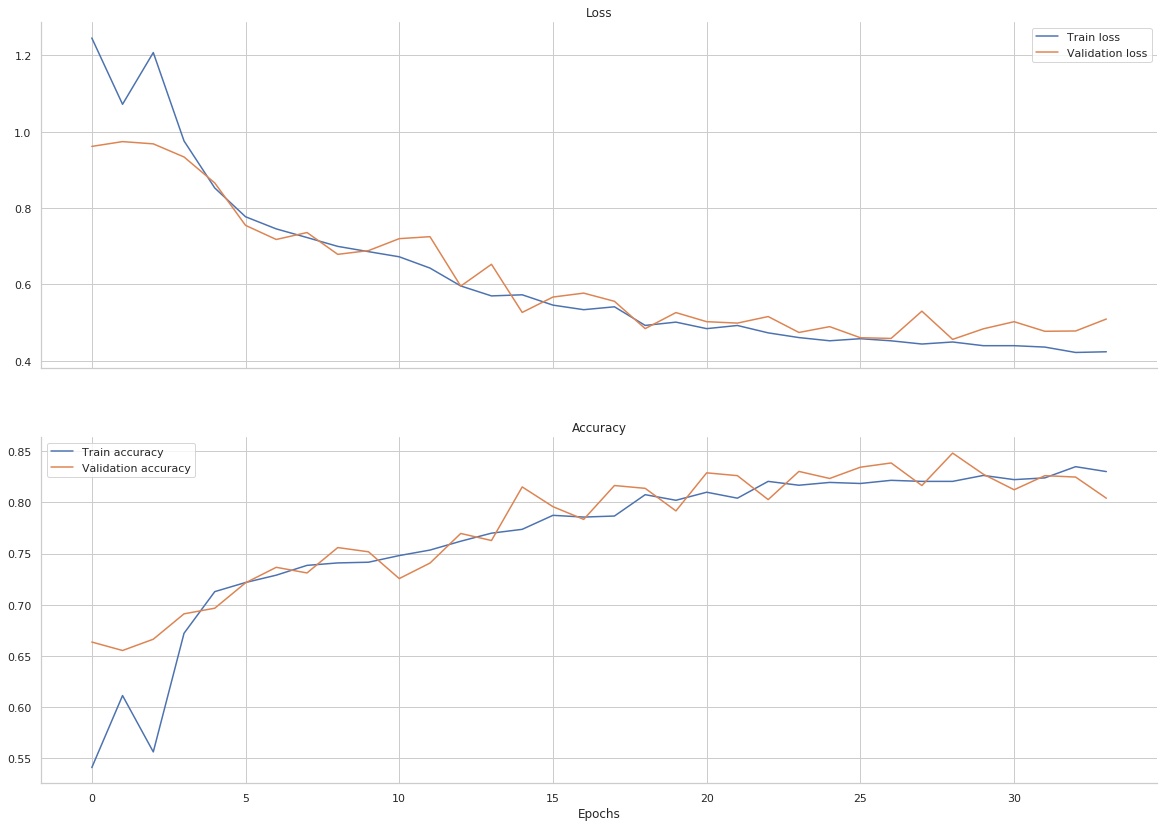

In [11]:
history = {'loss': history_warmup['loss'] + history_finetunning['loss'], 
           'val_loss': history_warmup['val_loss'] + history_finetunning['val_loss'], 
           'acc': history_warmup['acc'] + history_finetunning['acc'], 
           'val_acc': history_warmup['val_acc'] + history_finetunning['val_acc']}

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['acc'], label='Train accuracy')
ax2.plot(history['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

# Model Evaluation

## Confusion Matrix

In [12]:
# Create empty arays to keep the predictions and labels
lastFullTrainPred = np.empty((0, N_CLASSES))
lastFullTrainLabels = np.empty((0, N_CLASSES))
lastFullValPred = np.empty((0, N_CLASSES))
lastFullValLabels = np.empty((0, N_CLASSES))

# Add train predictions and labels
for i in range(STEP_SIZE_TRAIN+1):
    im, lbl = next(train_generator)
    scores = model.predict(im, batch_size=train_generator.batch_size)
    lastFullTrainPred = np.append(lastFullTrainPred, scores, axis=0)
    lastFullTrainLabels = np.append(lastFullTrainLabels, lbl, axis=0)

# Add validation predictions and labels
for i in range(STEP_SIZE_VALID+1):
    im, lbl = next(valid_generator)
    scores = model.predict(im, batch_size=valid_generator.batch_size)
    lastFullValPred = np.append(lastFullValPred, scores, axis=0)
    lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)
    
    
lastFullComPred = np.concatenate((lastFullTrainPred, lastFullValPred))
lastFullComLabels = np.concatenate((lastFullTrainLabels, lastFullValLabels))
complete_labels = [np.argmax(label) for label in lastFullComLabels]

train_preds = [np.argmax(pred) for pred in lastFullTrainPred]
train_labels = [np.argmax(label) for label in lastFullTrainLabels]
validation_preds = [np.argmax(pred) for pred in lastFullValPred]
validation_labels = [np.argmax(label) for label in lastFullValLabels]

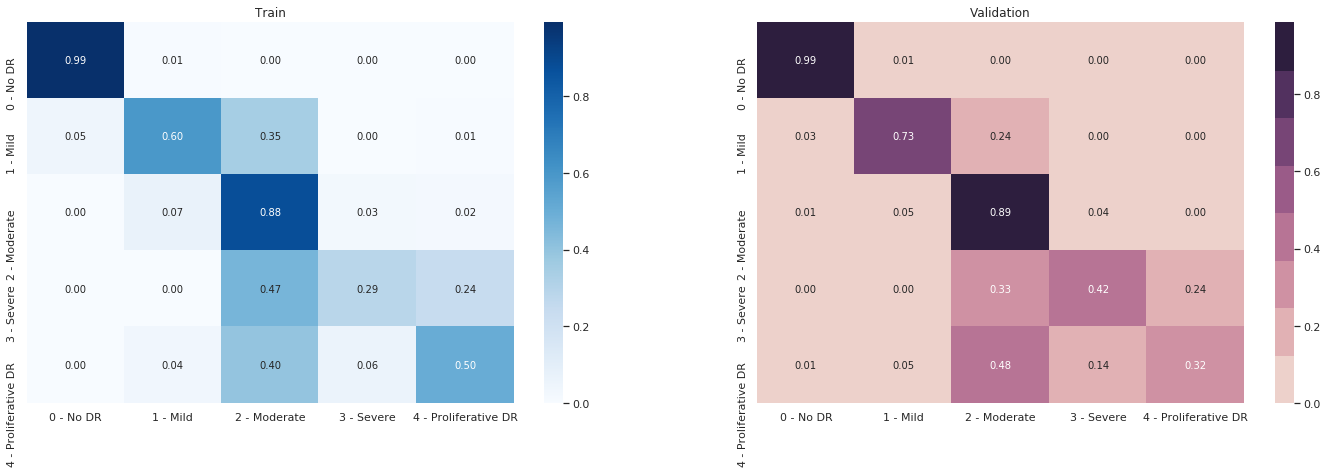

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 7))
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
train_cnf_matrix = confusion_matrix(train_labels, train_preds)
validation_cnf_matrix = confusion_matrix(validation_labels, validation_preds)

train_cnf_matrix_norm = train_cnf_matrix.astype('float') / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
validation_cnf_matrix_norm = validation_cnf_matrix.astype('float') / validation_cnf_matrix.sum(axis=1)[:, np.newaxis]

train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=labels, columns=labels)
validation_df_cm = pd.DataFrame(validation_cnf_matrix_norm, index=labels, columns=labels)

sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax1).set_title('Train')
sns.heatmap(validation_df_cm, annot=True, fmt='.2f', cmap=sns.cubehelix_palette(8), ax=ax2).set_title('Validation')
plt.show()

## Quadratic Weighted Kappa

In [14]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds,train_labels, weights='quadratic'))
print("Validation Cohen Kappa score: %.3f" % cohen_kappa_score(validation_preds, validation_labels, weights='quadratic'))
print("Complete set Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds+validation_preds, train_labels+validation_labels, weights='quadratic'))

Train Cohen Kappa score: 0.907
Validation Cohen Kappa score: 0.881
Complete set Cohen Kappa score: 0.902


In [16]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score
print("Train Accuracy: %.3f" % accuracy_score(train_labels,train_preds))
print("Validation Accuracy: %.3f" % accuracy_score(validation_labels, validation_preds))
print("Complete set Accuracy: %.3f" % accuracy_score(train_labels+validation_labels,train_preds+validation_preds))

Train Accuracy: 0.847
Validation Accuracy: 0.843
Complete set Accuracy: 0.846


# SHAP Model explainability

#### About SHAP's DeepExplainer from the [source repository](https://github.com/slundberg/shap#deep-learning-example-with-deepexplainer-tensorflowkeras-models): 
- Deep SHAP is a high-speed approximation algorithm for SHAP values in deep learning models that builds on a connection with [DeepLIFT](https://arxiv.org/abs/1704.02685) described in the SHAP NIPS paper. The implementation here differs from the original DeepLIFT by using a distribution of background samples instead of a single reference value, and using Shapley equations to linearize components such as max, softmax, products, divisions, etc.

### First let's see the images that we will explain

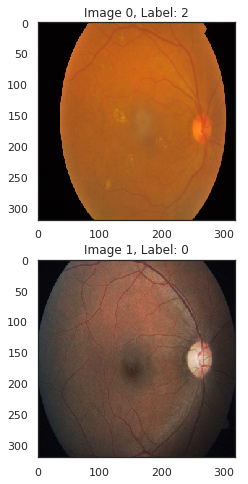

In [17]:
n_explain = 2
valid_generator.batch_size = 10 # background dataset
background, lbls = next(valid_generator)

sns.set_style("white")
plt.figure(figsize=[8, 8])
for index, image in enumerate(background[:n_explain]):
    plt.subplot(n_explain, 1, index+1)
    plt.imshow(image)
    plt.title("Image %s, Label: %s" % (index, np.argmax(lbls[index])))
    
plt.show()

### Now the SHAP explanation

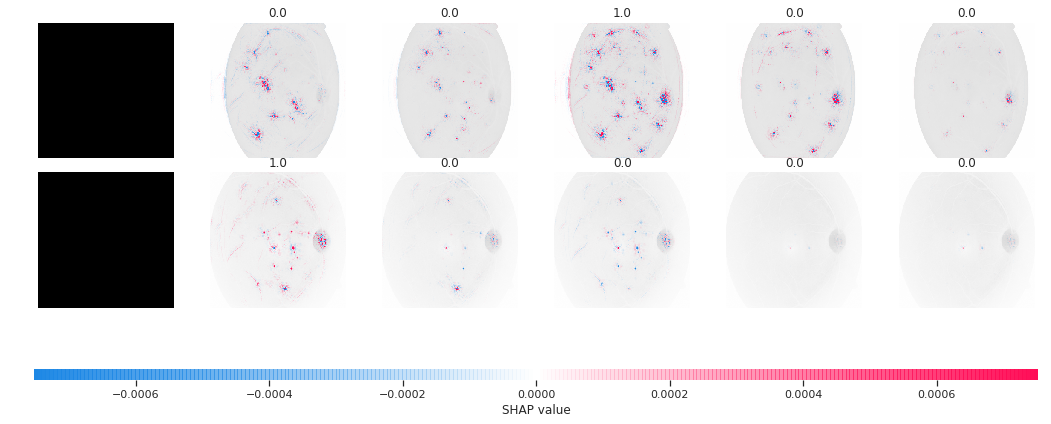

In [18]:
# explain predictions of the model on "n_explain" images
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(background)

# plot the feature attributions
shap.image_plot(shap_values, -background[:n_explain], labels=lbls, hspace=0.1)

- The plot above explains five outputs (our five levels of diabetic retinopathy 0-5) for three different images. Red pixels increase the model's output while blue pixels decrease the output. The input images are shown on the left (they are black because most of the pixels are greater than 0), and as nearly transparent grayscale backings behind each of the explanations. The sum of the SHAP values equals the difference between the expected model output (averaged over the background dataset, here I'm using 10 images) and the current model output. 
- Note that for the images that the label is "1.0" (the correct one), we a greater pink area.
- Labels that have as much pink area as the correct one are labels that our model probably doesn't have a high confidence prediction.

## Let's try on a few more images

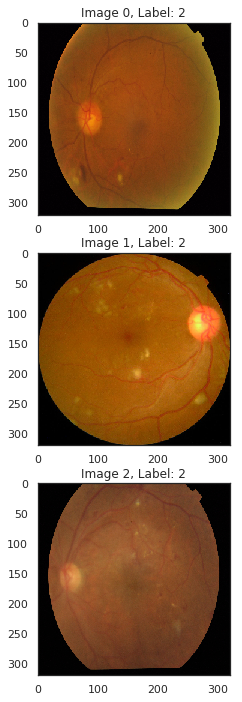

In [19]:
n_explain = 3
background, lbls = next(valid_generator)

sns.set_style("white")
plt.figure(figsize=[12, 12])
for index, image in enumerate(background[:n_explain]):
    plt.subplot(n_explain, 1, index+1)
    plt.imshow(image)
    plt.title("Image %s, Label: %s" % (index, np.argmax(lbls[index])))
    
plt.show()

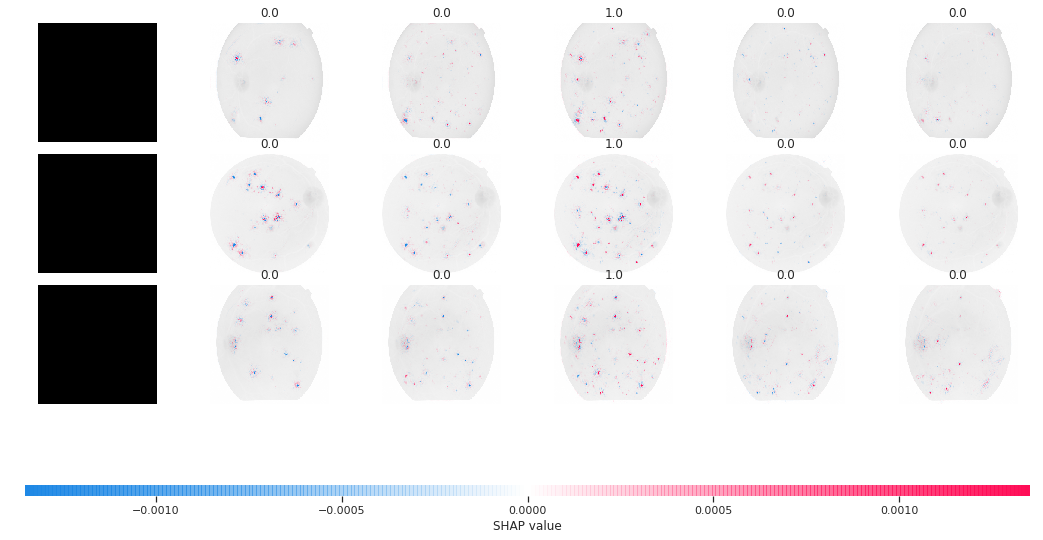

In [20]:
# explain predictions of the model on "n_explain" images
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(background)

# plot the feature attributions
shap.image_plot(shap_values, -background[:n_explain], labels=lbls, hspace=0.1)

## Apply model to test set and output predictions

In [21]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST)
predictions = [np.argmax(pred) for pred in preds]

filenames = test_generator.filenames
results = pd.DataFrame({'id_code':filenames, 'diagnosis':predictions})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])

# Predictions class distribution

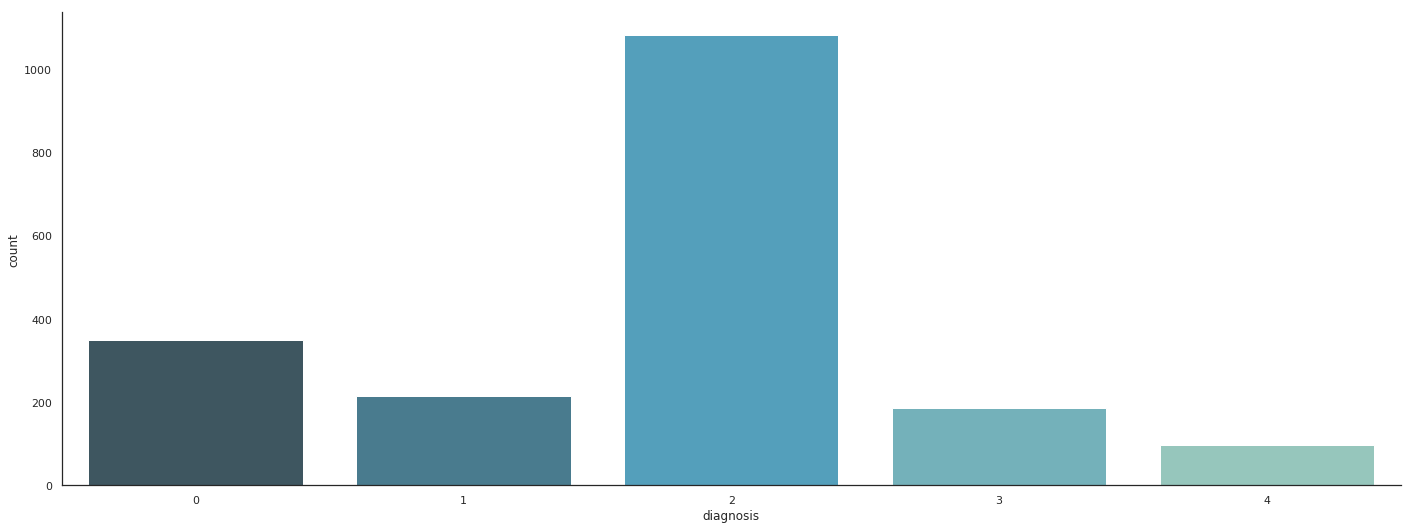

In [22]:
fig = plt.subplots(1, 1, sharex='col', figsize=(24, 8.7))
sns.countplot(x="diagnosis", data=results, palette="GnBu_d")
sns.despine()
plt.show()

In [23]:
results.to_csv('submission.csv', index=False)
results.head(10)

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,3
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,4
5,009c019a7309,2
6,010d915e229a,2
7,0111b949947e,0
8,01499815e469,3
9,0167076e7089,0


In [ ]:
model.save('vgg.h5')

In [26]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds,train_labels))
print("Validation Cohen Kappa score: %.3f" % cohen_kappa_score(validation_preds, validation_labels))

Train Cohen Kappa score: 0.764
Validation Cohen Kappa score: 0.761


In [ ]:
kaggle kernels output maryammahmoud/diabetic-retinopathy-shap-model-explainability -p /path/to/dest

kaggle kernels output maryammahmoud/diabetic-retinopathy-shap-model-explainability -p /path/to/dest

<a href="/kaggle/working/accuracy90.h5"> Download File </a>